As bankruptcy due to business failure can negatively affect the enterprise as well as the global economy, it is crucial to understand and predict whether a company is showing symptoms of getting bankrupt or not. The idea is to analyse the distresses in the corporate by taking into considerations different KPI’s of the company. These distresses often lead to bankruptcy of the company if not alerted at the right time. The problem statement is to develop a prediction model which will predict whether a company can go bankrupt or not. This will help the company to take appropriate decisions.

In [1]:
!pip install feature_engine
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, gc, joblib, re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, chi2, RFE, SequentialFeatureSelector
!pip install xgboost
from xgboost import XGBClassifier, XGBRFClassifier
!pip install catboost
from catboost import CatBoostClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
!pip install yellowbrick
from yellowbrick.classifier import ClassPredictionError

In [2]:
data = pd.read_csv('data.csv')
df=data.copy()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    #print("##################### Head #####################")
    #print(dataframe.head(3))
    #print("##################### Tail #####################")
    #print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)

##################### Shape #####################
(6819, 96)
##################### Types #####################
Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object
##################### NA #####################
Bankrupt?                                                   0
 ROA(C

In [4]:
df.drop(df.columns[df.nunique() == 1][0],axis=1,inplace=True)
df.columns = df.columns.str.replace(' ','')

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 6819
Variables: 95
cat_cols: 2
num_cols: 93
cat_but_car: 0
num_but_cat: 2


In [6]:
def outlier_thresholds(dataframe, variable, low_quantile=0.15, up_quantile=0.85):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
      col, check_outlier(df, col)

In [7]:

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

In [8]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

In [9]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(6819, 54)

BorderlineSMOTE works similarly to traditional SMOTE but with a few caveats. In order to overcome the shortcoming of SMOTE, it identifies two sets of points — Noise and Border. What are these peculiar points you ask? A point is called “Noise” if all its nearest neighbours belong to a different class (the majority). On the other hand, “Border” points are those that have a mix of majority and minority class points as their nearest neighbours.

![image.png](https://www.researchgate.net/publication/365584195/figure/fig2/AS:11431281098534768@1668976941016/Specific-groups-of-imbalanced-data-in-the-Borderline-SMOTE.png)

In [11]:
from sklearn.preprocessing import RobustScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)


In [12]:
from sklearn.decomposition import PCA


pca=PCA()
pca.fit(scaled_train_X)
exp_variance = pca.explained_variance_ratio_
cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)
pca = PCA(n_components=27,random_state=7)

train_pca = pca.fit_transform(scaled_train_X)

scaled_test_X = scaler.transform(X_test)
test_pca = pca.transform(scaled_test_X)

[0.1596778  0.2606052  0.34743063 0.39863184 0.44687238 0.48538984
 0.52089729 0.5545121  0.58576535 0.61121715 0.6339548  0.65504989
 0.67443827 0.69349594 0.71176888 0.7290693  0.74592486 0.76157183
 0.77650715 0.79131313 0.80556592 0.81907907 0.83239693 0.84458842
 0.85659243 0.86794833 0.87882667 0.88885291 0.89859906 0.90694428
 0.91469062 0.92185196 0.9289009  0.93561165 0.94206673 0.94760331
 0.95275339 0.95762626 0.96240875 0.96660042 0.97071104 0.97462841
 0.97817073 0.98139321 0.984443   0.98735434 0.99008344 0.99226952
 0.99435924 0.99610517 0.99784282 0.99905458 0.99974338 1.        ]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.60      0.20      0.31        44

    accuracy                           0.97      1364
   macro avg       0.79      0.60      0.64      1364
weighted avg       0.96      0.97      0.96      1364

--------------------------------------------------


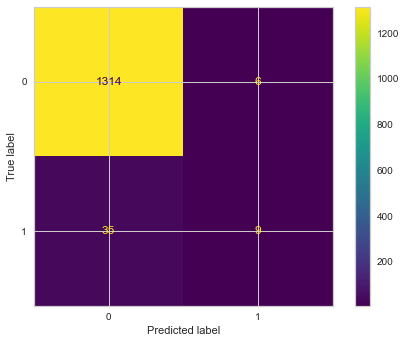

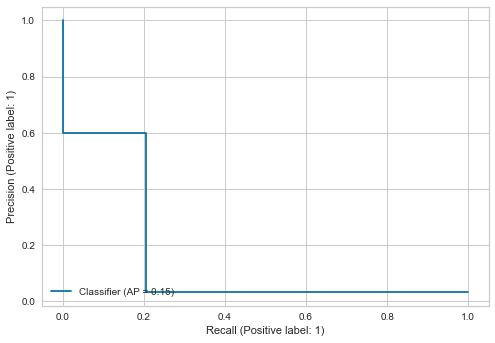

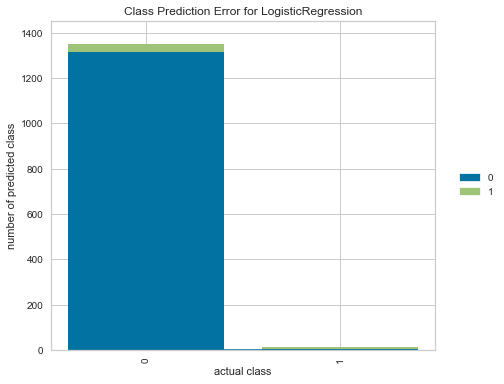

In [13]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def train_and_evaluate_model(model):
    model.fit(train_pca,y_train)
    y_pred = model.predict(test_pca)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')
    
    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(test_pca,y_test)
        visualizer.show()
        del visualizer
        
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()
train_and_evaluate_model(LogisticRegression())

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1320
           1       0.89      0.18      0.30        44

    accuracy                           0.97      1364
   macro avg       0.93      0.59      0.64      1364
weighted avg       0.97      0.97      0.96      1364

--------------------------------------------------


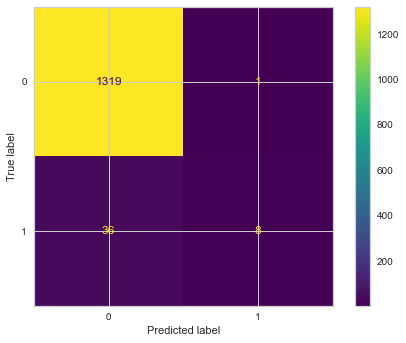

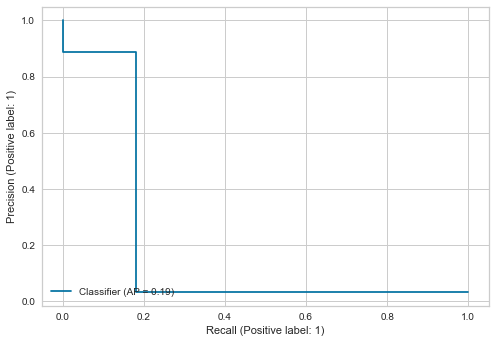

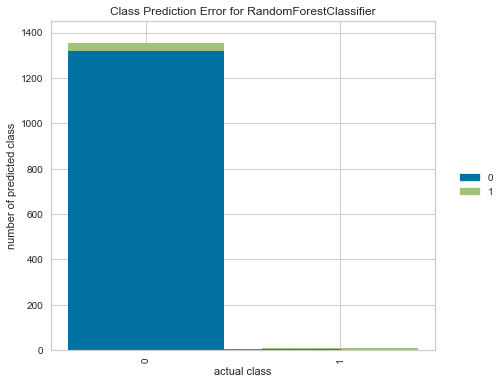

In [15]:
train_and_evaluate_model(RandomForestClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.60      0.27      0.37        44

    accuracy                           0.97      1364
   macro avg       0.79      0.63      0.68      1364
weighted avg       0.96      0.97      0.97      1364

--------------------------------------------------


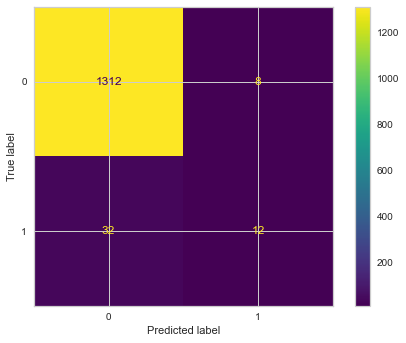

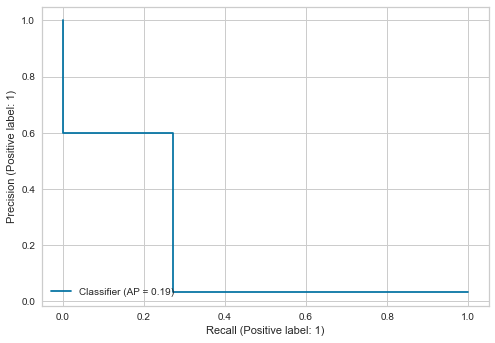

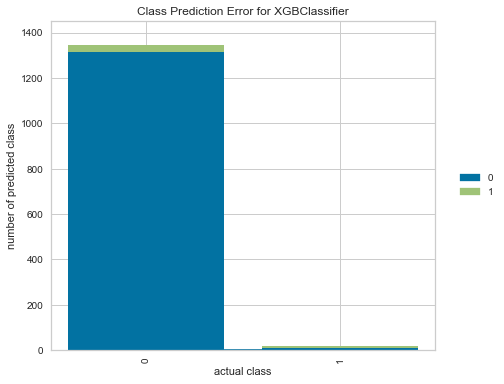

In [16]:
train_and_evaluate_model(XGBClassifier())

[LightGBM] [Info] Number of positive: 176, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032264 -> initscore=-3.401008
[LightGBM] [Info] Start training from score -3.401008
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1320
           1       0.75      0.27      0.40        44

    accuracy                           0.97      1364
   macro avg       0.86      0.63      0.69      1364
weighted avg       0.97      0.97      0.97      1364

--------------------------------------------------


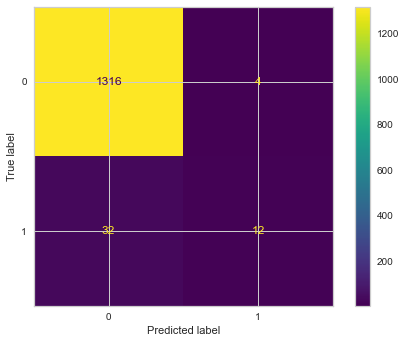

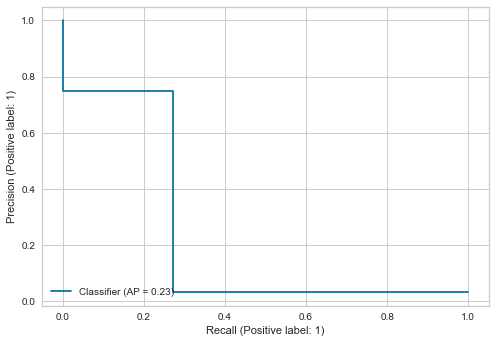

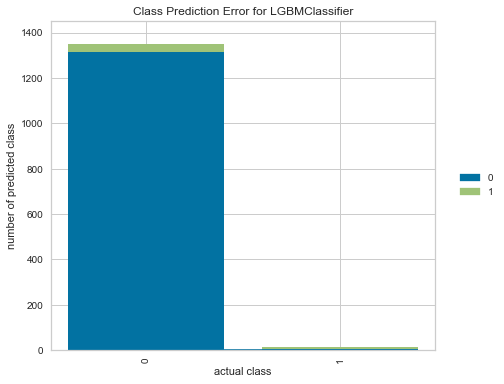

In [17]:
train_and_evaluate_model(LGBMClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1320
           1       0.65      0.30      0.41        44

    accuracy                           0.97      1364
   macro avg       0.81      0.65      0.70      1364
weighted avg       0.97      0.97      0.97      1364

--------------------------------------------------


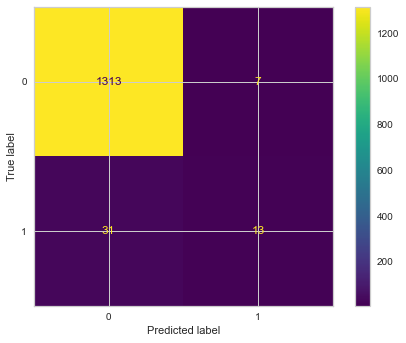

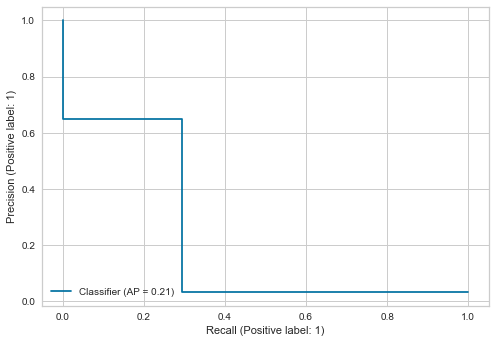

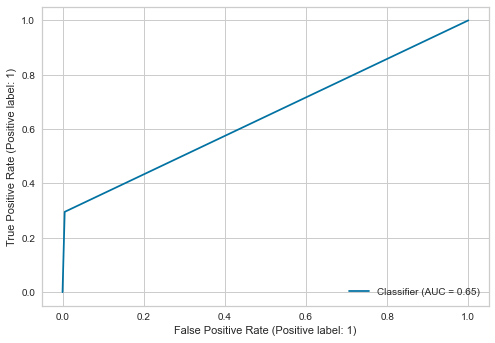

In [18]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1320
           1       0.45      0.20      0.28        44

    accuracy                           0.97      1364
   macro avg       0.71      0.60      0.63      1364
weighted avg       0.96      0.97      0.96      1364

--------------------------------------------------


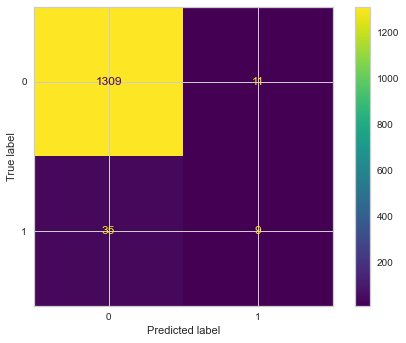

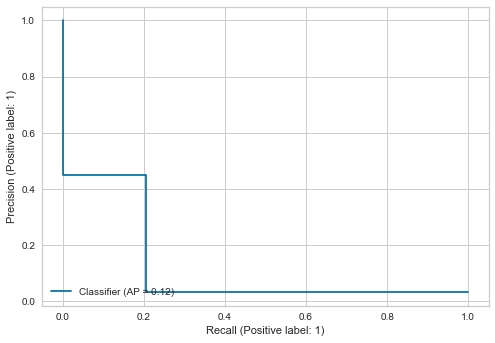

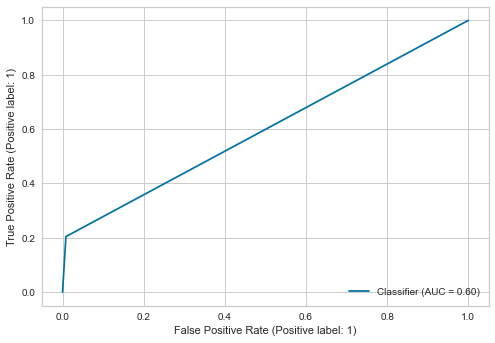

In [19]:
train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],final_estimator=RandomForestClassifier(),verbose=2))

In [20]:
model_perfs = pd.DataFrame({'Model': models, 
                            'Accuracy': accuracy_scores, 
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,LGBMClassifier(),0.973607,0.863131,0.634848,0.693253,0.634848
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.972874,0.931160,0.590530,0.644028,0.590530
2,<catboost.core.CatBoostClassifier object at 0x...,0.972141,0.813467,0.645076,0.695993,0.645076
3,"XGBClassifier(base_score=None, booster=None, c...",0.970674,0.788095,0.633333,0.679992,0.633333
4,LogisticRegression(),0.969941,0.787027,0.600000,0.644862,0.600000
5,"StackingClassifier(estimators=[('ET', ExtraTre...",0.966276,0.711979,0.598106,0.631991,0.598106
